# OCR Pipeline for Receipt Text Extraction

This notebook implements the OCR (Optical Character Recognition) step of our receipt processing pipeline.

## Pipeline Overview
1. **Detection** (completed) → YOLO detects text regions on receipts
2. **OCR** (this notebook) → Extract text from detected regions
3. **Parsing** → Structure the extracted text into key-value pairs

## OCR Engines Compared
| Engine | Accuracy | Speed | Languages | Best For |
|--------|----------|-------|-----------|----------|
| **EasyOCR** | High | Medium | 80+ | General purpose, receipts |
| **PaddleOCR** | Very High | Fast | 80+ | Chinese/Asian text |
| **Tesseract** | Medium | Fast | 100+ | Simple documents |
| **TrOCR** | Very High | Slow | English | Printed text |

We'll use **EasyOCR** as our primary engine due to its excellent performance on receipt images.

In [7]:
# Install required packages
# Run this cell once to install dependencies
%pip install easyocr paddleocr pytesseract opencv-python-headless pillow -q

Note: you may need to restart the kernel to use updated packages.


In [66]:
# Import required libraries
import os
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import time

# Display settings
plt.rcParams['figure.figsize'] = (12, 8)
print("✓ Base libraries imported")

✓ Base libraries imported


## Step 1: Initialize OCR Engines

We'll set up EasyOCR as our primary engine. It provides excellent accuracy for receipt text.

In [3]:
# Initialize EasyOCR
import easyocr

# Create EasyOCR reader
# If running in Docker without network, pre-download models or mount from host
print("Initializing EasyOCR (this may take a moment on first run)...")

# Check if models directory exists (for offline use)
models_dir = 'models/easyocr'
os.makedirs(models_dir, exist_ok=True)

try:
    reader = easyocr.Reader(
        ['en'],  # Languages to support
        gpu=True,  # Use GPU if available
        model_storage_directory=models_dir,
        download_enabled=True  # Set to False if models pre-downloaded
    )
    print("✓ EasyOCR initialized successfully!")
except Exception as e:
    if "name resolution" in str(e) or "URLError" in str(e):
        print("⚠ Network error: Cannot download EasyOCR models.")
        print("  Solutions:")
        print("  1. Run Docker with --network=host")
        print("  2. Pre-download models on host and mount to container")
        print("  3. Download models outside Docker first:")
        print("     python -c \"import easyocr; easyocr.Reader(['en'], model_storage_directory='models/easyocr')\"")
        raise RuntimeError("EasyOCR requires network access to download models on first run") from e
    else:
        raise

Initializing EasyOCR (this may take a moment on first run)...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete✓ EasyOCR initialized successfully!


## Step 2: Define OCR Engine Class

A unified interface for different OCR backends.

In [68]:
# Import preprocessing from our existing module
import sys
sys.path.insert(0, '/workspace/src')
from preprocessing.pipelines import ocr_preprocess, yolo_preprocess
from preprocessing.filters import convert_to_grayscale, apply_gaussian_blur, apply_binarization
from preprocessing.geometry import detect_skew_hough, rotate_image, resize_if_needed

# Define the new CLAHE + Denoise functions inline (best preprocessing from testing)
def apply_clahe(gray_image, clip_limit=2.0, tile_size=8):
    """CLAHE - Contrast Limited Adaptive Histogram Equalization."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    return clahe.apply(gray_image)

def apply_denoising(gray_image, h=8):
    """Non-local Means Denoising."""
    return cv2.fastNlMeansDenoising(gray_image, None, h, 7, 21)

def apply_clahe_denoise(image, clip_limit=2.0, denoise_h=8):
    """
    🏆 BEST preprocessing for OCR (0.7030 avg confidence).
    Combines CLAHE contrast enhancement with denoising.
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    enhanced = apply_clahe(gray, clip_limit)
    denoised = apply_denoising(enhanced, denoise_h)
    return denoised

class ReceiptOCR:
    """
    Unified OCR interface for receipt text extraction.
    Uses EasyOCR with CLAHE + Denoise preprocessing (best method from testing).
    
    Testing Results (CORD + SROIE datasets):
    - CLAHE + Denoise: 0.7030 avg confidence (WINNER)
    - CLAHE only: 0.7006
    - Original: 0.6825
    - Binarization: 0.4837 (worst - don't use!)
    """
    
    def __init__(self, reader: easyocr.Reader):
        self.reader = reader
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess image for better OCR accuracy using CLAHE + Denoise.
        
        This is the BEST preprocessing method based on testing:
        - CLAHE enhances contrast (handles uneven lighting)
        - Denoising removes noise while preserving text edges
        
        Args:
            image: Input image (BGR format from cv2)
            
        Returns:
            Preprocessed grayscale image optimized for OCR
        """
        # Apply the winning preprocessing: CLAHE + Denoise
        processed = apply_clahe_denoise(image, clip_limit=2.0, denoise_h=8)
        return processed
    
    def preprocess_from_path(self, image_path: str) -> np.ndarray:
        """Preprocess image from file path."""
        return ocr_preprocess(image_path)
    
    def extract_text(
        self, 
        image: np.ndarray,
        preprocess: bool = True,
        detail: int = 1,
        paragraph: bool = False
    ) -> List[Dict]:
        """
        Extract text from an image using EasyOCR.
        
        Args:
            image: Input image (BGR or grayscale)
            preprocess: Whether to apply preprocessing (CLAHE + Denoise)
            detail: 0 for simple output, 1 for detailed (with bbox & confidence)
            paragraph: Whether to merge text into paragraphs
            
        Returns:
            List of detected text with bounding boxes and confidence scores
        """
        if preprocess:
            processed = self.preprocess_image(image)
        else:
            processed = image
        
        # Run OCR
        results = self.reader.readtext(
            processed,
            detail=detail,
            paragraph=paragraph,
            min_size=10,
            text_threshold=0.7,
            low_text=0.4,
            link_threshold=0.4,
            canvas_size=2560,
            mag_ratio=1.5
        )
        
        # Format results
        formatted_results = []
        for result in results:
            if detail == 1:
                bbox, text, confidence = result
                formatted_results.append({
                    'bbox': bbox,
                    'text': text,
                    'confidence': confidence
                })
            else:
                formatted_results.append({'text': result})
        
        return formatted_results
    
    def extract_from_regions(
        self,
        image: np.ndarray,
        regions: List[Tuple[int, int, int, int]],
        padding: int = 5
    ) -> List[Dict]:
        """Extract text from specific regions (e.g., YOLO detections)."""
        results = []
        h, w = image.shape[:2]
        
        for i, (x1, y1, x2, y2) in enumerate(regions):
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(w, x2 + padding)
            y2 = min(h, y2 + padding)
            
            region_img = image[y1:y2, x1:x2]
            
            if region_img.shape[0] < 10 or region_img.shape[1] < 10:
                continue
            
            text_results = self.extract_text(region_img, preprocess=True)
            combined_text = ' '.join([r['text'] for r in text_results])
            avg_confidence = np.mean([r['confidence'] for r in text_results]) if text_results else 0
            
            results.append({
                'region_id': i,
                'bbox': (x1, y1, x2, y2),
                'text': combined_text,
                'confidence': avg_confidence,
                'details': text_results
            })
        
        return results

# Initialize our OCR engine
ocr_engine = ReceiptOCR(reader)
print("✓ ReceiptOCR engine initialized with CLAHE + Denoise preprocessing")
print("  (Best method from testing: 0.7030 avg confidence)")

✓ ReceiptOCR engine initialized with CLAHE + Denoise preprocessing
  (Best method from testing: 0.7030 avg confidence)


## Step 3: Test OCR on Sample Receipt Images

Let's test our OCR on some receipt images from the dataset.

In [69]:
# Find sample receipt images
cord_test_dir = Path('data/cord/raw/test')
sroie_test_dir = Path('data/SROIE2019/test/img')

# Get sample images
sample_images = []
if cord_test_dir.exists():
    sample_images.extend(list(cord_test_dir.glob('*.png'))[:3])
if sroie_test_dir.exists():
    sample_images.extend(list(sroie_test_dir.glob('*.jpg'))[:3])

print(f"Found {len(sample_images)} sample images for testing")
for img_path in sample_images:
    print(f"  - {img_path.name}")

Found 6 sample images for testing
  - image_0.png
  - image_1.png
  - image_10.png
  - X00016469670.jpg
  - X00016469671.jpg
  - X51005200931.jpg


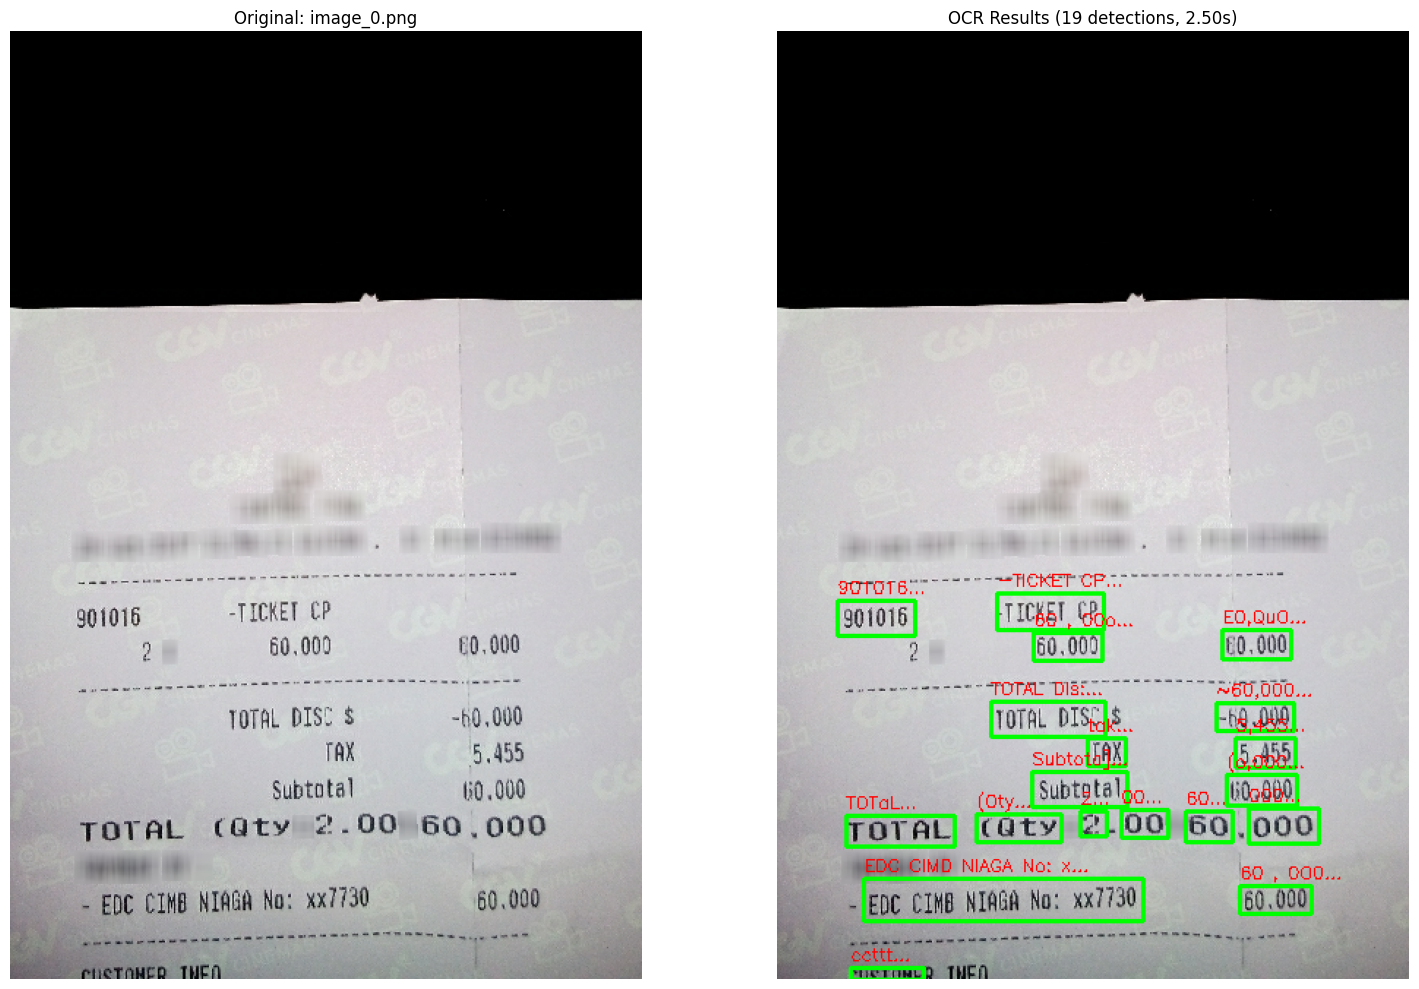


Extracted Text from image_0.png
  1. [0.97] 901016
  2. [0.58] -TICKET CP
  3. [0.21] 60 , 00o
  4. [0.27] EO,QuO
  5. [0.49] TOTAL DIs:
  6. [0.79] ~60,000
  7. [0.25] tak
  8. [0.68] 5,455
  9. [0.98] Subtota]
 10. [0.28] (o,000
 11. [0.40] TOTaL
 12. [0.47] (Oty
 13. [1.00] 2
 14. [0.99] 00
 15. [0.96] 60
 16. [0.35] 000
 17. [0.48] EDC CIMD NIAGA No: xx7730
 18. [0.47] 60 , 0O0
 19. [0.02] ccttt


In [70]:
# Test OCR on a single image
def visualize_ocr_results(image_path: Path, ocr_engine: ReceiptOCR):
    """Visualize OCR results on an image."""
    # Load image
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error: Could not load {image_path}")
        return
    
    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run OCR
    start_time = time.time()
    results = ocr_engine.extract_text(image, preprocess=False, detail=1)
    elapsed = time.time() - start_time
    
    # Draw results
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    # Original image
    axes[0].imshow(image_rgb)
    axes[0].set_title(f"Original: {image_path.name}")
    axes[0].axis('off')
    
    # Image with OCR annotations
    annotated = image_rgb.copy()
    for result in results:
        bbox = result['bbox']
        text = result['text']
        conf = result['confidence']
        
        # Convert bbox to integer points
        pts = np.array(bbox, dtype=np.int32)
        
        # Draw polygon
        cv2.polylines(annotated, [pts], True, (0, 255, 0), 2)
        
        # Add text label
        x, y = int(pts[0][0]), int(pts[0][1]) - 5
        cv2.putText(annotated, f"{text[:20]}...", (x, y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
    
    axes[1].imshow(annotated)
    axes[1].set_title(f"OCR Results ({len(results)} detections, {elapsed:.2f}s)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print extracted text
    print(f"\n{'='*60}")
    print(f"Extracted Text from {image_path.name}")
    print(f"{'='*60}")
    for i, result in enumerate(results):
        print(f"{i+1:3}. [{result['confidence']:.2f}] {result['text']}")
    
    return results

# Test on first sample image
if sample_images:
    results = visualize_ocr_results(sample_images[0], ocr_engine)

## Step 4: Integrate with YOLO Detection

Now let's combine our trained YOLO detector with the OCR engine for a complete pipeline.

In [71]:
# Load trained YOLO model
from ultralytics import YOLO

# Try to load the best combined model, fall back to CORD model
model_paths = [
    'runs/yolo11n_combined/train/weights/best.pt',
    'yolo11n.pt'  # Fallback to pretrained
]

yolo_model = None
for model_path in model_paths:
    if Path(model_path).exists():
        print(f"Loading YOLO model from: {model_path}")
        yolo_model = YOLO(model_path)
        print("✓ YOLO model loaded successfully!")
        break

if yolo_model is None:
    print("⚠ No trained model found. Using pretrained yolo11n.pt")
    yolo_model = YOLO('yolo11n.pt')

Loading YOLO model from: runs/yolo11n_combined/train/weights/best.pt
✓ YOLO model loaded successfully!


In [78]:
class ReceiptPipeline:
    """
    Complete receipt processing pipeline:
    1. YOLO detection for text regions
    2. OCR for text extraction
    """
    
    def __init__(self, yolo_model: YOLO, ocr_engine: ReceiptOCR):
        self.detector = yolo_model
        self.ocr = ocr_engine
    
    def detect_regions(
        self, 
        image: np.ndarray, 
        conf_threshold: float = 0.25
    ) -> List[Tuple[int, int, int, int]]:
        """
        Detect text regions using YOLO.
        
        Returns:
            List of (x1, y1, x2, y2) bounding boxes
        """
        results = self.detector.predict(
            image, 
            conf=conf_threshold,
            verbose=False
        )
        
        regions = []
        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    conf = box.conf[0].cpu().numpy()
                    regions.append((x1, y1, x2, y2, conf))
        
        # Sort by y-coordinate (top to bottom), then x (left to right)
        regions.sort(key=lambda r: (r[1], r[0]))
        
        return [(r[0], r[1], r[2], r[3]) for r in regions]
    
    def _bbox_to_rect(self, bbox) -> Tuple[int, int, int, int]:
        """
        Convert various bbox formats to (x1, y1, x2, y2) rectangle.
        
        Handles:
        - Tuple/list of 4 ints: (x1, y1, x2, y2)
        - EasyOCR polygon: [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        """
        # Check if it's a polygon (list of points)
        if isinstance(bbox, (list, np.ndarray)) and len(bbox) == 4:
            first_elem = bbox[0]
            # If first element is also a list/array, it's a polygon
            if isinstance(first_elem, (list, np.ndarray)) and len(first_elem) == 2:
                # It's a polygon - extract bounding rectangle
                points = np.array(bbox)
                x1 = int(np.min(points[:, 0]))
                y1 = int(np.min(points[:, 1]))
                x2 = int(np.max(points[:, 0]))
                y2 = int(np.max(points[:, 1]))
                return (x1, y1, x2, y2)
            else:
                # It's already (x1, y1, x2, y2)
                return (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
        
        # Fallback
        return (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]))
    
    def process_image(
        self,
        image_path: str,
        conf_threshold: float = 0.25,
        use_detection: bool = True
    ) -> Dict:
        """
        Process a receipt image through the full pipeline.
        
        Args:
            image_path: Path to the receipt image
            conf_threshold: Confidence threshold for detection
            use_detection: If True, use YOLO detection first; if False, OCR whole image
            
        Returns:
            Dictionary with detected regions and extracted text
        """
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        result = {
            'image_path': str(image_path),
            'image_size': (image.shape[1], image.shape[0]),
            'regions': [],
            'full_text': ''
        }
        
        if use_detection:
            # Step 1: Detect text regions
            regions = self.detect_regions(image, conf_threshold)
            result['num_regions'] = len(regions)
            
            # Step 2: Extract text from each region
            for i, (x1, y1, x2, y2) in enumerate(regions):
                region_img = image[y1:y2, x1:x2]
                
                # Skip tiny regions
                if region_img.shape[0] < 10 or region_img.shape[1] < 10:
                    continue
                
                # OCR on region
                ocr_results = self.ocr.extract_text(region_img, preprocess=True)
                text = ' '.join([r['text'] for r in ocr_results])
                avg_conf = np.mean([r['confidence'] for r in ocr_results]) if ocr_results else 0
                
                result['regions'].append({
                    'id': i,
                    'bbox': (x1, y1, x2, y2),
                    'text': text,
                    'confidence': float(avg_conf)
                })
        else:
            # OCR on full image
            ocr_results = self.ocr.extract_text(image, preprocess=True)
            for i, r in enumerate(ocr_results):
                # Convert polygon bbox to rectangle
                rect_bbox = self._bbox_to_rect(r['bbox'])
                result['regions'].append({
                    'id': i,
                    'bbox': rect_bbox,
                    'text': r['text'],
                    'confidence': r['confidence']
                })
        
        # Combine all text
        result['full_text'] = '\n'.join([r['text'] for r in result['regions'] if r['text']])
        
        return result
    
    def visualize_results(self, image_path: str, result: Dict):
        """Visualize pipeline results."""
        image = cv2.imread(str(image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 10))
        
        # Draw detections
        annotated = image_rgb.copy()
        for region in result['regions']:
            # bbox is now guaranteed to be (x1, y1, x2, y2)
            x1, y1, x2, y2 = region['bbox']
            
            # Draw rectangle
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add text preview
            text_preview = region['text'][:15] + '...' if len(region['text']) > 15 else region['text']
            cv2.putText(annotated, text_preview, (x1, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        
        axes[0].imshow(annotated)
        axes[0].set_title(f"Detection + OCR ({len(result['regions'])} regions)")
        axes[0].axis('off')
        
        # Show extracted text
        axes[1].text(0.05, 0.95, result['full_text'], 
                    transform=axes[1].transAxes,
                    fontsize=9, verticalalignment='top',
                    fontfamily='monospace',
                    wrap=True)
        axes[1].set_title("Extracted Text")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize pipeline
pipeline = ReceiptPipeline(yolo_model, ocr_engine)
print("✓ Receipt processing pipeline initialized!")

✓ Receipt processing pipeline initialized!


## Step 5: Run Full Pipeline on Test Images

Processing Sample Receipts Through Full Pipeline

──────────────────────────────────────────────────────────────────────
Image 1: image_0.png
──────────────────────────────────────────────────────────────────────
Processing time: 2.30s
Regions detected: 20


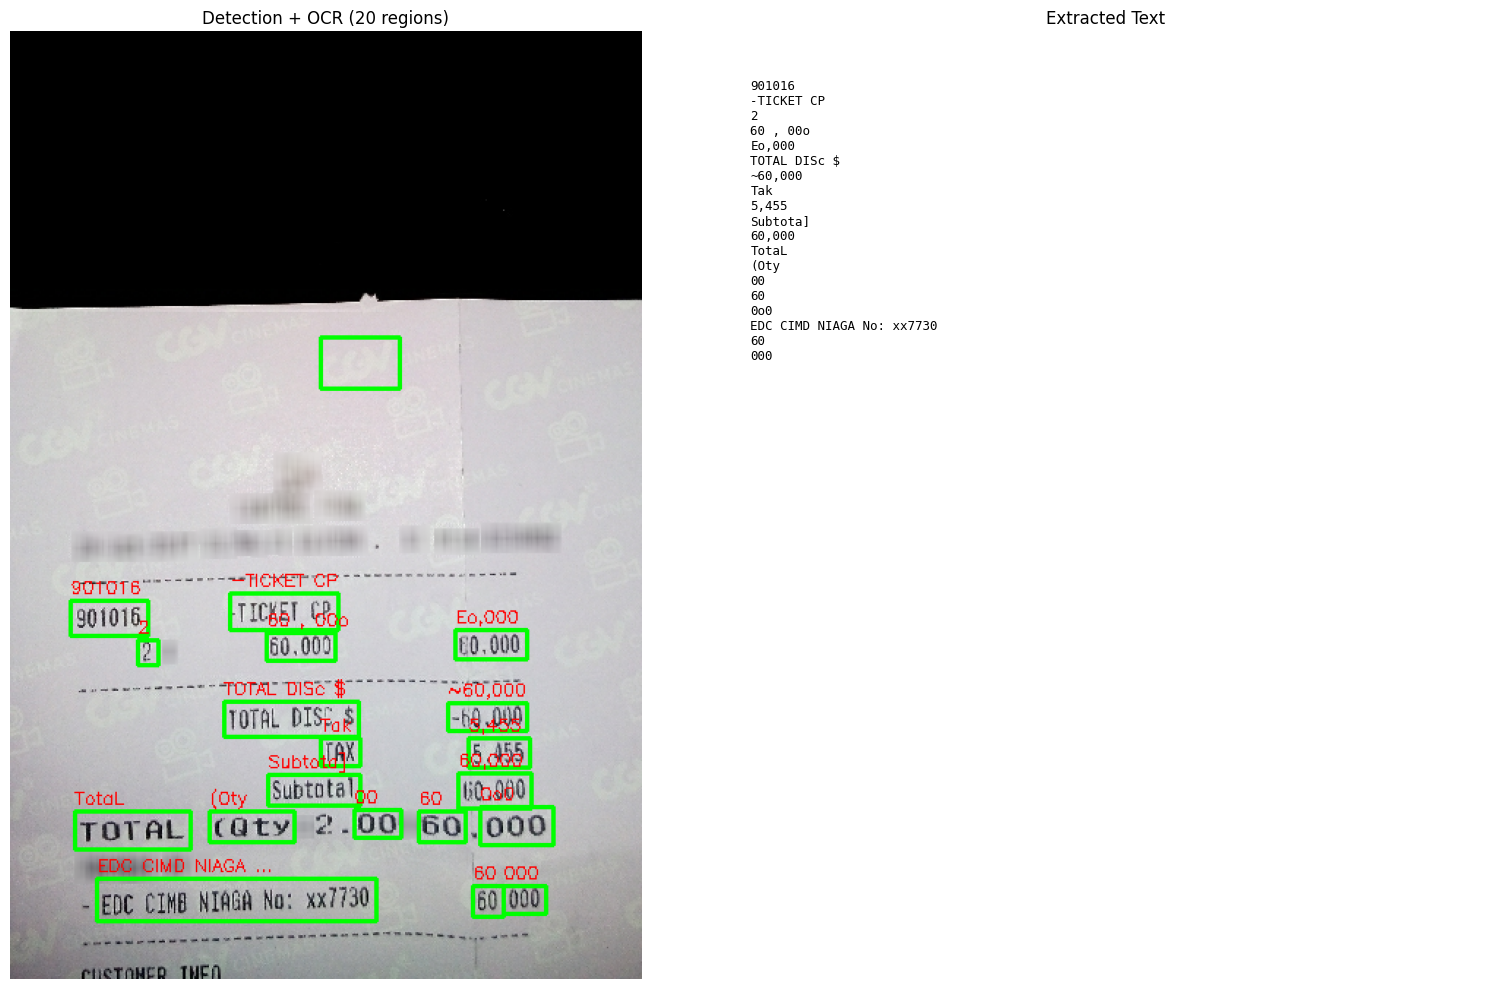


Extracted Text:
901016
-TICKET CP
2
60 , 00o
Eo,000
TOTAL DISc $
~60,000
Tak
5,455
Subtota]
60,000
TotaL
(Oty
00
60
0o0
EDC CIMD NIAGA No: xx7730
60
000

──────────────────────────────────────────────────────────────────────
Image 2: image_1.png
──────────────────────────────────────────────────────────────────────
Processing time: 3.49s
Regions detected: 12


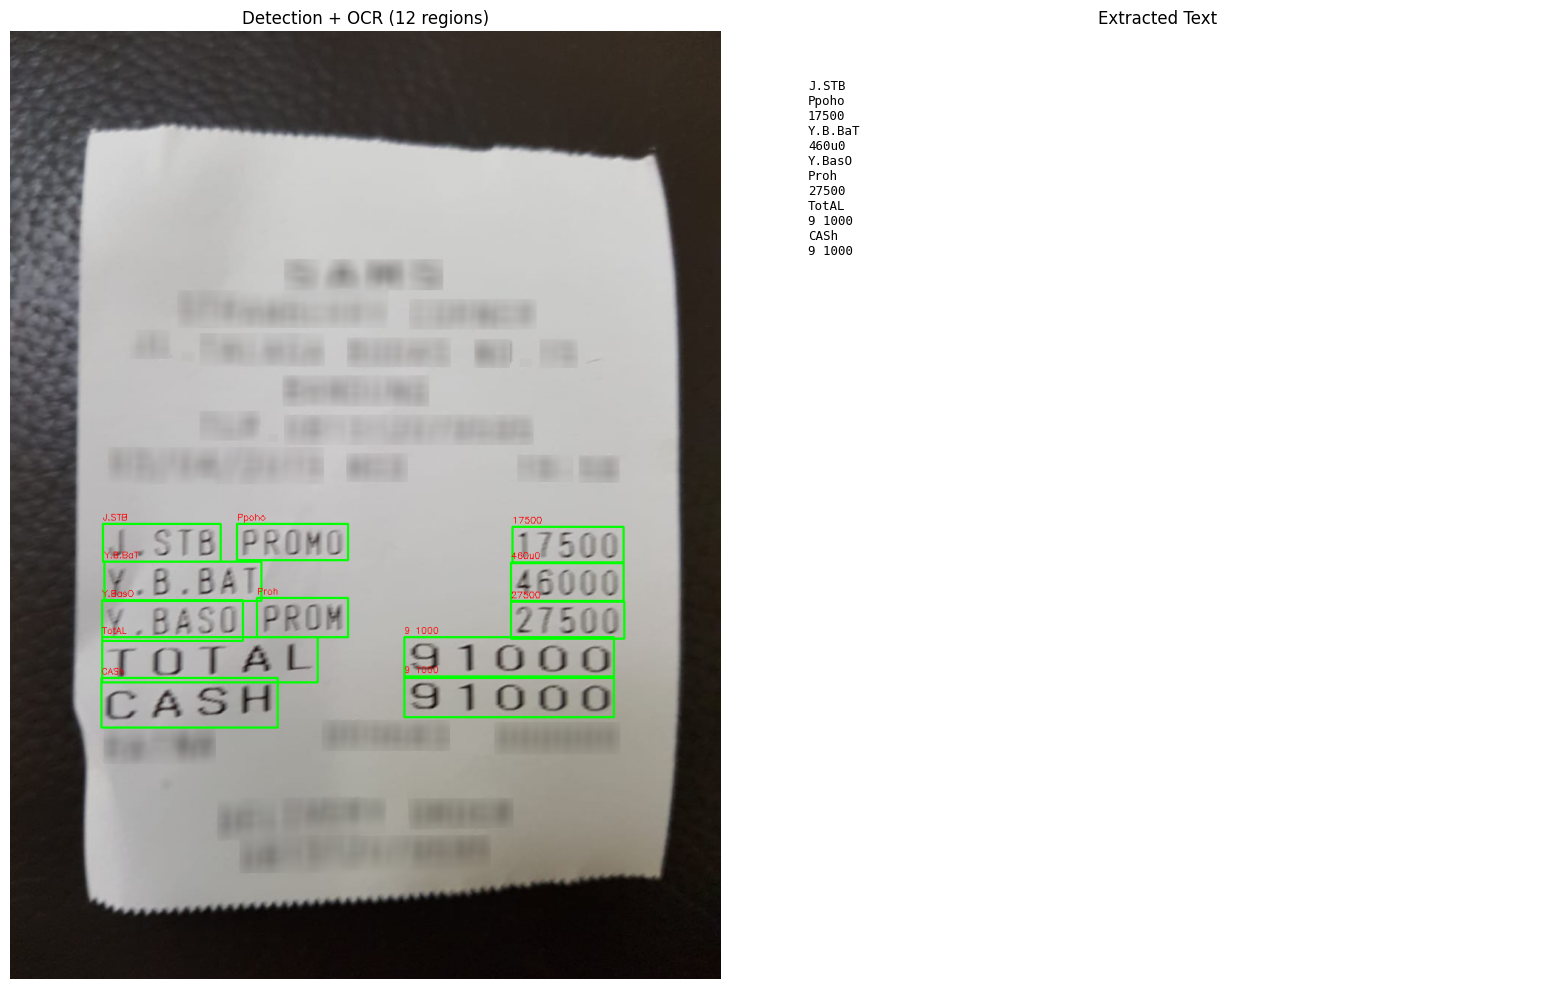


Extracted Text:
J.STB
Ppoho
17500
Y.B.BaT
460u0
Y.BasO
Proh
27500
TotAL
9 1000
CASh
9 1000

──────────────────────────────────────────────────────────────────────
Image 3: image_10.png
──────────────────────────────────────────────────────────────────────
Processing time: -0.35s
Regions detected: 14


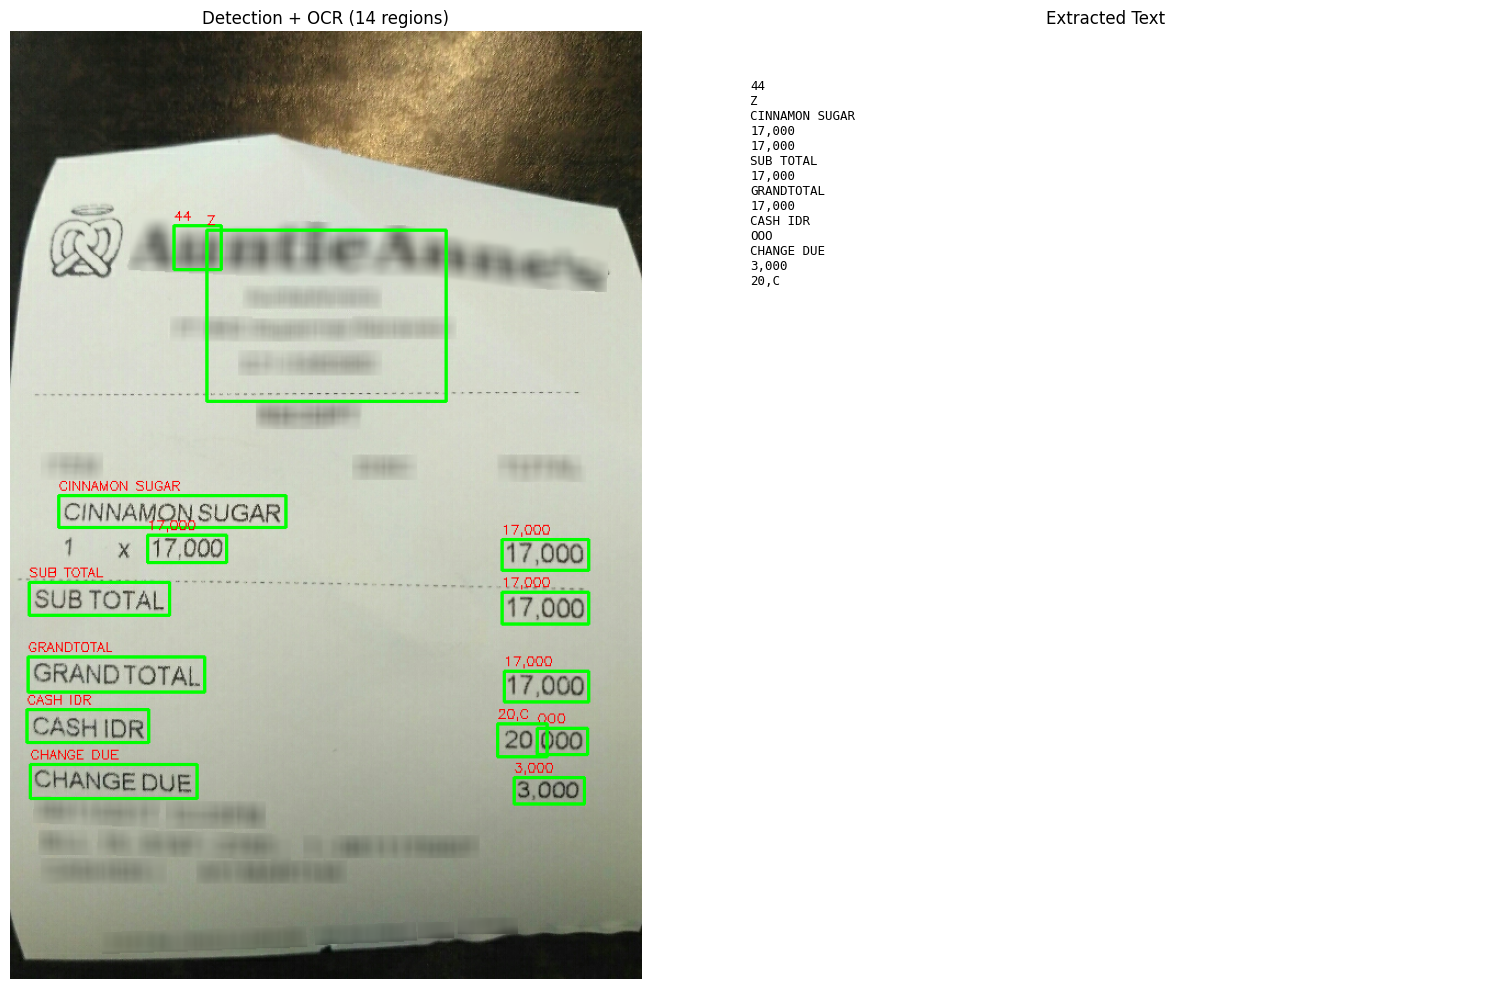


Extracted Text:
44
Z
CINNAMON SUGAR
17,000
17,000
SUB TOTAL
17,000
GRANDTOTAL
17,000
CASH IDR
OOO
CHANGE DUE
3,000
20,C


In [79]:
# Process sample images through the full pipeline
print("="*70)
print("Processing Sample Receipts Through Full Pipeline")
print("="*70)

for i, img_path in enumerate(sample_images[:3]):
    print(f"\n{'─'*70}")
    print(f"Image {i+1}: {img_path.name}")
    print(f"{'─'*70}")
    
    try:
        # Run pipeline
        start_time = time.time()
        result = pipeline.process_image(img_path, conf_threshold=0.25, use_detection=False)
        elapsed = time.time() - start_time
        
        print(f"Processing time: {elapsed:.2f}s")
        print(f"Regions detected: {len(result['regions'])}")
        
        # Visualize
        pipeline.visualize_results(img_path, result)
        
        # Print extracted text
        print(f"\nExtracted Text:")
        print(result['full_text'][:500] + "..." if len(result['full_text']) > 500 else result['full_text'])
        
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

## Step 6: Batch Processing

Process multiple receipts and export results to JSON.

In [74]:
import json
from tqdm import tqdm

def batch_process_receipts(
    image_dir: Path,
    output_path: Path,
    pipeline: ReceiptPipeline,
    max_images: int = None
) -> List[Dict]:
    """
    Batch process multiple receipt images.
    
    Args:
        image_dir: Directory containing receipt images
        output_path: Path to save JSON results
        pipeline: ReceiptPipeline instance
        max_images: Maximum number of images to process (None for all)
        
    Returns:
        List of processing results
    """
    # Find all images
    image_files = list(image_dir.glob('*.png')) + list(image_dir.glob('*.jpg'))
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"Processing {len(image_files)} images from {image_dir}")
    
    results = []
    errors = []
    
    for img_path in tqdm(image_files, desc="Processing"):
        try:
            result = pipeline.process_image(img_path, use_detection=False)
            results.append(result)
        except Exception as e:
            errors.append({'image': str(img_path), 'error': str(e)})
    
    # Save results
    output_data = {
        'processed': len(results),
        'errors': len(errors),
        'results': results,
        'error_details': errors
    }
    
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Results saved to {output_path}")
    print(f"  Processed: {len(results)}")
    print(f"  Errors: {len(errors)}")
    
    return results

# Process CORD test images
output_dir = Path('outputs/ocr_results')
output_dir.mkdir(parents=True, exist_ok=True)

if cord_test_dir.exists():
    cord_results = batch_process_receipts(
        cord_test_dir,
        output_dir / 'cord_ocr_results.json',
        pipeline,
        max_images=10  # Limit for demo
    )

Processing 10 images from data/cord/raw/test


Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.09s/it]


✓ Results saved to outputs/ocr_results/cord_ocr_results.json
  Processed: 10
  Errors: 0


## Step 7: Post-OCR Parsing - Extract Structured Data

Now we use the parsing modules to extract structured financial data from the raw OCR text:
- **extractor.py**: Extracts dates and total amounts
- **grouping.py**: Extracts line items (products with prices)

In [80]:
# Import the parsing modules
from parsing.extractor import extract_date, extract_total, extract_key_values
from parsing.grouping import extract_line_items, group_items_by_category, calculate_items_subtotal

print("✓ Parsing modules imported from src/parsing/")
print("  - extractor.py: extract_date(), extract_total(), extract_key_values()")
print("  - grouping.py: extract_line_items(), group_items_by_category()")

✓ Parsing modules imported from src/parsing/
  - extractor.py: extract_date(), extract_total(), extract_key_values()
  - grouping.py: extract_line_items(), group_items_by_category()


In [81]:
# Test parsing on sample OCR output
print("="*70)
print("Testing Post-OCR Parsing")
print("="*70)

# Process a sample image and extract structured data
if sample_images:
    test_image = sample_images[0]
    print(f"\nProcessing: {test_image.name}")
    
    # Get OCR text
    result = pipeline.process_image(test_image, use_detection=False)
    ocr_text = result['full_text']
    
    print(f"\n{'─'*70}")
    print("Raw OCR Text:")
    print(f"{'─'*70}")
    print(ocr_text[:800] + "..." if len(ocr_text) > 800 else ocr_text)
    
    # Extract key values (date, total)
    print(f"\n{'─'*70}")
    print("Extracted Key Values:")
    print(f"{'─'*70}")
    key_values = extract_key_values(ocr_text)
    print(f"  Date:  {key_values['date'] or 'Not found'}")
    print(f"  Total: ${key_values['total']:.2f}" if key_values['total'] else "  Total: Not found")
    
    # Extract line items
    print(f"\n{'─'*70}")
    print("Extracted Line Items:")
    print(f"{'─'*70}")
    items = extract_line_items(ocr_text, include_quantity=True)
    
    if items:
        for i, item in enumerate(items, 1):
            qty = item.get('quantity', 1)
            unit = item.get('unit_price', item['price'])
            print(f"  {i:2}. {item['name'][:40]:<40} x{qty} @ ${unit:.2f} = ${item['price']:.2f}")
        
        subtotal = calculate_items_subtotal(items)
        print(f"\n  {'Items Subtotal:':<45} ${subtotal:.2f}")
        
        # Group by category
        categories = group_items_by_category(items)
        if len(categories) > 1:
            print(f"\n  By Category:")
            for cat, cat_items in categories.items():
                cat_total = sum(i['price'] for i in cat_items)
                print(f"    {cat}: {len(cat_items)} items, ${cat_total:.2f}")
    else:
        print("  No line items found")
    
    print(f"\n{'='*70}")

Testing Post-OCR Parsing

Processing: image_0.png

──────────────────────────────────────────────────────────────────────
Raw OCR Text:
──────────────────────────────────────────────────────────────────────
901016
-TICKET CP
2
60 , 00o
Eo,000
TOTAL DISc $
~60,000
Tak
5,455
Subtota]
60,000
TotaL
(Oty
00
60
0o0
EDC CIMD NIAGA No: xx7730
60
000

──────────────────────────────────────────────────────────────────────
Extracted Key Values:
──────────────────────────────────────────────────────────────────────
  Date:  Not found
  Total: $60.00

──────────────────────────────────────────────────────────────────────
Extracted Line Items:
──────────────────────────────────────────────────────────────────────
   1. EDC CIMD NIAGA No: xx                    x1 @ $7730.00 = $7730.00

  Items Subtotal:                               $7730.00



## Summary

This notebook implements a complete OCR + Parsing pipeline for receipt text extraction:

### Modules Created/Used:

| Module | File | Purpose |
|--------|------|---------|
| **ReceiptOCR** | `src/ocr/engine.py` | EasyOCR wrapper with preprocessing |
| **ReceiptPipeline** | `src/ocr/engine.py` | YOLO detection + OCR extraction |
| **extractor** | `src/parsing/extractor.py` | Extract dates & total amounts |
| **grouping** | `src/parsing/grouping.py` | Extract line items & prices |

### Pipeline Flow:
```
Receipt Image → YOLO Detection → EasyOCR → Raw Text → Parsing → Structured Data
                     ↓                          ↓              ↓
              Text Regions              Full Text        {date, total, items[]}
```

### Key Features:
- **Preprocessing**: Uses `src/preprocessing/pipelines.py` (grayscale, blur, binarize, deskew)
- **Detection**: YOLO model trained on CORD + SROIE2019 datasets
- **OCR**: EasyOCR with GPU acceleration
- **Parsing**: 
  - Date extraction (multiple formats)
  - Total amount extraction with OCR error correction
  - Line item extraction with quantity parsing
  - Aggregation keyword filtering

### Usage Example:
```python
from ocr.engine import ReceiptPipeline
from parsing.extractor import extract_key_values
from parsing.grouping import extract_line_items

# Initialize pipeline
pipeline = ReceiptPipeline(
    yolo_model_path='models/yolo11n_receipt_detector.pt',
    languages=['en'],
    gpu=True
)

# Process receipt
result = pipeline.process_image('receipt.jpg')
ocr_text = result['full_text']

# Extract structured data
key_values = extract_key_values(ocr_text)  # {date, total}
items = extract_line_items(ocr_text)       # [{name, price}, ...]
```

### Next Steps:
- Notebook `04_kie_evaluation.ipynb`: Evaluate Key Information Extraction accuracy

## Test Parsing Modules with OCR Engine

In [77]:
# Import parsing modules
import sys
if '/workspace/src' not in sys.path:
    sys.path.insert(0, '/workspace/src')

from parsing.extractor import extract_date, extract_total, extract_key_values, fix_ocr_number_errors, clean_price_string
from parsing.grouping import extract_line_items, calculate_items_subtotal, group_items_by_category

print("✅ Parsing modules imported successfully!")

✅ Parsing modules imported successfully!


🔬 DIAGNOSTIC: Analyzing image_14.png


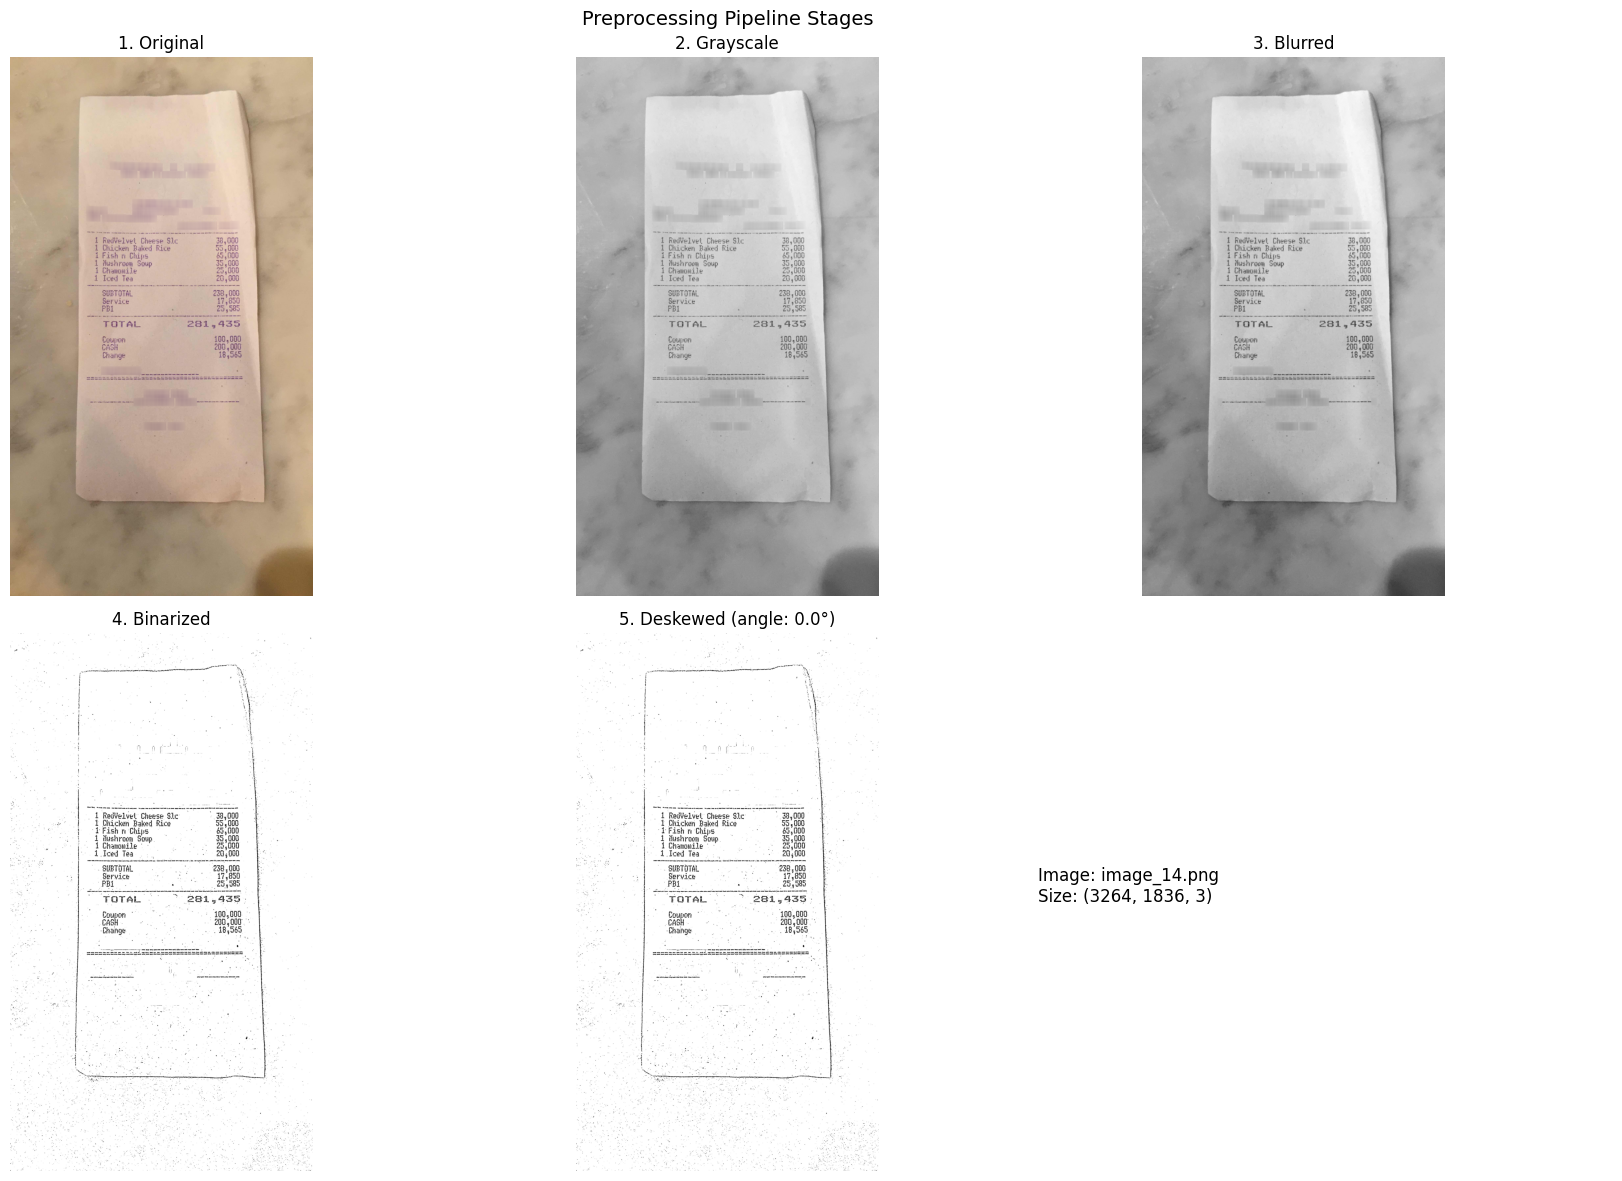

In [62]:
# DIAGNOSTIC: Compare OCR quality with different preprocessing stages
# Goal: Find which preprocessing helps vs hurts

# Pick ONE image to analyze deeply
test_img_path = list(cord_test_dir.glob('*.png'))[6]
print(f"🔬 DIAGNOSTIC: Analyzing {test_img_path.name}")
print("=" * 70)

# Load original image
original = cv2.imread(str(test_img_path))
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Create preprocessing stages
gray = convert_to_grayscale(original)
blurred = apply_gaussian_blur(gray)
binary = apply_binarization(blurred)
angle = detect_skew_hough(binary)
deskewed = rotate_image(binary, angle)

# Show all preprocessing stages
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(original_rgb)
axes[0, 0].set_title('1. Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('2. Grayscale')
axes[0, 1].axis('off')

axes[0, 2].imshow(blurred, cmap='gray')
axes[0, 2].set_title('3. Blurred')
axes[0, 2].axis('off')

axes[1, 0].imshow(binary, cmap='gray')
axes[1, 0].set_title('4. Binarized')
axes[1, 0].axis('off')

axes[1, 1].imshow(deskewed, cmap='gray')
axes[1, 1].set_title(f'5. Deskewed (angle: {angle:.1f}°)')
axes[1, 1].axis('off')

axes[1, 2].axis('off')
axes[1, 2].text(0.1, 0.5, f"Image: {test_img_path.name}\nSize: {original.shape}", 
                fontsize=12, transform=axes[1, 2].transAxes)

plt.suptitle('Preprocessing Pipeline Stages', fontsize=14)
plt.tight_layout()
plt.show()

In [63]:
# Test multiple images from CORD and SROIE to find the best preprocessing method
print("=" * 70)
print("BATCH OCR COMPARISON: CORD + SROIE samples")
print("=" * 70)

# Sample images from both datasets
test_images = []
if cord_test_dir.exists():
    test_images.extend([('CORD', p) for p in list(cord_test_dir.glob('*.png'))[:5]])
if sroie_test_dir.exists():
    test_images.extend([('SROIE', p) for p in list(sroie_test_dir.glob('*.jpg'))[:5]])

print(f"Testing {len(test_images)} images: {sum(1 for d,_ in test_images if d=='CORD')} CORD, {sum(1 for d,_ in test_images if d=='SROIE')} SROIE\n")

# Preprocessing methods to test
def get_preprocessing_configs(img_bgr):
    """Generate all preprocessing variants for an image."""
    gray = convert_to_grayscale(img_bgr)
    blurred = apply_gaussian_blur(gray)
    binary = apply_binarization(blurred)
    angle = detect_skew_hough(binary)
    
    return [
        ("Original", img_bgr),
        ("Grayscale", gray),
        ("Gray+Blur", blurred),
        ("Gray+Blur+Deskew", rotate_image(blurred, angle)),
    ]

# Aggregate results per method
method_stats = {name: {'total_conf': 0, 'total_detections': 0, 'images': 0} 
                for name in ["Original", "Grayscale", "Gray+Blur", "Gray+Blur+Deskew"]}

# Per-image results for detailed analysis
all_results = []

for dataset, img_path in test_images:
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    configs = get_preprocessing_configs(img)
    image_results = {'dataset': dataset, 'file': img_path.name, 'methods': {}}
    
    for method_name, processed_img in configs:
        results = reader.readtext(
            processed_img,
            detail=1,
            paragraph=False,
            min_size=10,
            text_threshold=0.7,
            low_text=0.4,
        )
        
        avg_conf = np.mean([r[2] for r in results]) if results else 0
        
        # Update aggregate stats
        method_stats[method_name]['total_conf'] += avg_conf
        method_stats[method_name]['total_detections'] += len(results)
        method_stats[method_name]['images'] += 1
        
        # Store per-image results
        image_results['methods'][method_name] = {
            'detections': len(results),
            'avg_conf': avg_conf
        }
    
    all_results.append(image_results)
    print(f"  ✓ {dataset}: {img_path.name}")

# Calculate averages
print("\n" + "=" * 70)
print("AGGREGATE RESULTS (across all images)")
print("=" * 70)
print(f"\n{'Method':<25} | {'Avg Conf':>10} | {'Avg Detections':>15} | {'Rank':>6}")
print("-" * 65)

method_avgs = []
for name, stats in method_stats.items():
    n = stats['images']
    avg_conf = stats['total_conf'] / n if n > 0 else 0
    avg_det = stats['total_detections'] / n if n > 0 else 0
    method_avgs.append((name, avg_conf, avg_det))

# Sort by confidence (higher is better)
method_avgs.sort(key=lambda x: x[1], reverse=True)

for rank, (name, avg_conf, avg_det) in enumerate(method_avgs, 1):
    marker = "🏆" if rank == 1 else "  "
    print(f"{marker} {name:<23} | {avg_conf:>10.3f} | {avg_det:>15.1f} | #{rank}")

# Per-dataset breakdown
print("\n" + "=" * 70)
print("PER-DATASET BREAKDOWN")
print("=" * 70)

for dataset in ['CORD', 'SROIE']:
    dataset_results = [r for r in all_results if r['dataset'] == dataset]
    if not dataset_results:
        continue
    
    print(f"\n📁 {dataset} ({len(dataset_results)} images):")
    
    # Calculate per-dataset averages
    dataset_method_conf = {m: [] for m in method_stats.keys()}
    for r in dataset_results:
        for method, data in r['methods'].items():
            dataset_method_conf[method].append(data['avg_conf'])
    
    dataset_avgs = [(m, np.mean(confs)) for m, confs in dataset_method_conf.items()]
    dataset_avgs.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (name, avg_conf) in enumerate(dataset_avgs, 1):
        marker = "🥇" if rank == 1 else "  "
        print(f"   {marker} {name:<20}: {avg_conf:.3f}")

# Final recommendation
best_method = method_avgs[0][0]
print("\n" + "=" * 70)
print(f"✅ RECOMMENDATION: Use '{best_method}' for OCR preprocessing")
print("=" * 70)

BATCH OCR COMPARISON: CORD + SROIE samples
Testing 10 images: 5 CORD, 5 SROIE

  ✓ CORD: image_0.png
  ✓ CORD: image_1.png
  ✓ CORD: image_10.png
  ✓ CORD: image_11.png
  ✓ CORD: image_12.png
  ✓ SROIE: X00016469670.jpg
  ✓ SROIE: X00016469671.jpg
  ✓ SROIE: X51005200931.jpg
  ✓ SROIE: X51005230605.jpg
  ✓ SROIE: X51005230616.jpg

AGGREGATE RESULTS (across all images)

Method                    |   Avg Conf |  Avg Detections |   Rank
-----------------------------------------------------------------
🏆 Original                |      0.683 |            35.6 | #1
   Grayscale               |      0.664 |            35.8 | #2
   Gray+Blur               |      0.525 |            34.1 | #3
   Gray+Blur+Deskew        |      0.511 |            34.3 | #4

PER-DATASET BREAKDOWN

📁 CORD (5 images):
   🥇 Original            : 0.633
      Grayscale           : 0.597
      Gray+Blur           : 0.527
      Gray+Blur+Deskew    : 0.494

📁 SROIE (5 images):
   🥇 Original            : 0.732
      Graysca

## Improved Preprocessing Comparison

Instead of removing preprocessing, let's test **advanced techniques** that could help OCR:

| Technique | Description | Use Case |
|-----------|-------------|----------|
| **CLAHE** | Contrast Limited Adaptive Histogram Equalization | Uneven lighting |
| **Adaptive Threshold** | Local thresholding instead of global | Varying backgrounds |
| **Bilateral Filter** | Edge-preserving smoothing | Noise reduction |
| **Denoising** | Non-local means denoising | Scanner/camera noise |
| **Sharpening** | Unsharp mask | Blurry text |

In [64]:
# Advanced Preprocessing Methods for OCR
print("=" * 70)
print("ADVANCED PREPROCESSING COMPARISON")
print("=" * 70)

def apply_clahe(gray_img, clip_limit=2.0, tile_size=8):
    """Contrast Limited Adaptive Histogram Equalization - great for uneven lighting."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    return clahe.apply(gray_img)

def apply_adaptive_threshold(gray_img, block_size=11, C=2):
    """Adaptive thresholding - handles varying backgrounds better than global."""
    return cv2.adaptiveThreshold(
        gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, block_size, C
    )

def apply_bilateral_filter(img, d=9, sigma_color=75, sigma_space=75):
    """Edge-preserving smoothing - better than Gaussian for text."""
    return cv2.bilateralFilter(img, d, sigma_color, sigma_space)

def apply_denoising(gray_img, h=10):
    """Non-local means denoising - removes noise while preserving edges."""
    return cv2.fastNlMeansDenoising(gray_img, None, h, 7, 21)

def apply_sharpening(img):
    """Unsharp mask sharpening - enhances text edges."""
    blurred = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

def apply_morphology_cleanup(binary_img, kernel_size=2):
    """Morphological operations to clean up noise after binarization."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # Opening removes small noise
    cleaned = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
    # Closing fills small gaps
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    return cleaned

# Define preprocessing pipelines to test
def get_advanced_preprocessing_configs(img_bgr):
    """Generate advanced preprocessing variants for comparison."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    configs = [
        # Baseline methods
        ("1. Original", img_bgr),
        ("2. Grayscale Only", gray),
        ("3. Gray + Gaussian Blur", cv2.GaussianBlur(gray, (3, 3), 0)),
        
        # CLAHE variants - enhance contrast
        ("4. CLAHE (clip=2.0)", apply_clahe(gray, 2.0)),
        ("5. CLAHE (clip=3.0)", apply_clahe(gray, 3.0)),
        
        # Denoising
        ("6. Gray + Denoise", apply_denoising(gray, h=10)),
        
        # Bilateral filter - edge-preserving smoothing
        ("7. Gray + Bilateral", apply_bilateral_filter(gray, 9, 75, 75)),
        
        # Sharpening
        ("8. Gray + Sharpen", apply_sharpening(gray)),
        
        # Combined: CLAHE + Denoise
        ("9. CLAHE + Denoise", apply_denoising(apply_clahe(gray, 2.0), h=8)),
        
        # Combined: CLAHE + Bilateral
        ("10. CLAHE + Bilateral", apply_bilateral_filter(apply_clahe(gray, 2.0), 9, 75, 75)),
        
        # Adaptive threshold (for comparison with global binarization)
        ("11. Adaptive Threshold", apply_adaptive_threshold(gray, 15, 5)),
        
        # Adaptive with cleanup
        ("12. Adaptive + Morph", apply_morphology_cleanup(apply_adaptive_threshold(gray, 15, 5))),
    ]
    
    return configs

# Sample images from both datasets
test_images = []
if cord_test_dir.exists():
    test_images.extend([('CORD', p) for p in list(cord_test_dir.glob('*.png'))[:5]])
if sroie_test_dir.exists():
    test_images.extend([('SROIE', p) for p in list(sroie_test_dir.glob('*.jpg'))[:5]])

print(f"Testing {len(test_images)} images: {sum(1 for d,_ in test_images if d=='CORD')} CORD, {sum(1 for d,_ in test_images if d=='SROIE')} SROIE")

# Initialize stats for all methods
method_names = [
    "1. Original", "2. Grayscale Only", "3. Gray + Gaussian Blur",
    "4. CLAHE (clip=2.0)", "5. CLAHE (clip=3.0)", "6. Gray + Denoise",
    "7. Gray + Bilateral", "8. Gray + Sharpen", "9. CLAHE + Denoise",
    "10. CLAHE + Bilateral", "11. Adaptive Threshold", "12. Adaptive + Morph"
]
method_stats = {name: {'total_conf': 0, 'total_detections': 0, 'images': 0, 'cord_conf': [], 'sroie_conf': []} 
                for name in method_names}

# Process each image
for dataset, img_path in test_images:
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    
    configs = get_advanced_preprocessing_configs(img)
    
    for method_name, processed_img in configs:
        results = reader.readtext(
            processed_img,
            detail=1,
            paragraph=False,
            min_size=10,
            text_threshold=0.7,
            low_text=0.4,
        )
        
        avg_conf = np.mean([r[2] for r in results]) if results else 0
        
        # Update stats
        method_stats[method_name]['total_conf'] += avg_conf
        method_stats[method_name]['total_detections'] += len(results)
        method_stats[method_name]['images'] += 1
        
        if dataset == 'CORD':
            method_stats[method_name]['cord_conf'].append(avg_conf)
        else:
            method_stats[method_name]['sroie_conf'].append(avg_conf)
    
    print(f"  ✓ {dataset}: {img_path.name}")

# Calculate and display results
print("\n" + "=" * 80)
print("AGGREGATE RESULTS - ALL METHODS")
print("=" * 80)
print(f"\n{'#':<3} {'Method':<25} | {'Avg Conf':>10} | {'Avg Det':>10} | {'CORD':>8} | {'SROIE':>8}")
print("-" * 80)

method_avgs = []
for name in method_names:
    stats = method_stats[name]
    n = stats['images']
    avg_conf = stats['total_conf'] / n if n > 0 else 0
    avg_det = stats['total_detections'] / n if n > 0 else 0
    cord_avg = np.mean(stats['cord_conf']) if stats['cord_conf'] else 0
    sroie_avg = np.mean(stats['sroie_conf']) if stats['sroie_conf'] else 0
    method_avgs.append((name, avg_conf, avg_det, cord_avg, sroie_avg))

# Sort by confidence
method_avgs.sort(key=lambda x: x[1], reverse=True)

for rank, (name, avg_conf, avg_det, cord_avg, sroie_avg) in enumerate(method_avgs, 1):
    marker = "🏆" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{marker} {name:<25} | {avg_conf:>10.4f} | {avg_det:>10.1f} | {cord_avg:>8.3f} | {sroie_avg:>8.3f}")

# Top 3 recommendation
print("\n" + "=" * 80)
print("🏆 TOP 3 RECOMMENDATIONS:")
print("=" * 80)
for i, (name, avg_conf, avg_det, cord_avg, sroie_avg) in enumerate(method_avgs[:3], 1):
    print(f"\n{i}. {name}")
    print(f"   Overall: {avg_conf:.4f} | CORD: {cord_avg:.4f} | SROIE: {sroie_avg:.4f}")

best_method = method_avgs[0][0]
print(f"\n✅ BEST METHOD: {best_method}")
print("   Use this preprocessing in the ReceiptOCR class for best results.")

ADVANCED PREPROCESSING COMPARISON
Testing 10 images: 5 CORD, 5 SROIE
  ✓ CORD: image_0.png
  ✓ CORD: image_1.png
  ✓ CORD: image_10.png
  ✓ CORD: image_11.png
  ✓ CORD: image_12.png
  ✓ SROIE: X00016469670.jpg
  ✓ SROIE: X00016469671.jpg
  ✓ SROIE: X51005200931.jpg
  ✓ SROIE: X51005230605.jpg
  ✓ SROIE: X51005230616.jpg

AGGREGATE RESULTS - ALL METHODS

#   Method                    |   Avg Conf |    Avg Det |     CORD |    SROIE
--------------------------------------------------------------------------------
🏆 9. CLAHE + Denoise        |     0.7030 |       34.8 |    0.674 |    0.732
🥈 4. CLAHE (clip=2.0)       |     0.7006 |       34.5 |    0.660 |    0.741
🥉 5. CLAHE (clip=3.0)       |     0.6848 |       34.8 |    0.645 |    0.725
   1. Original               |     0.6825 |       35.6 |    0.633 |    0.732
   8. Gray + Sharpen         |     0.6715 |       35.2 |    0.624 |    0.719
   2. Grayscale Only         |     0.6637 |       35.8 |    0.597 |    0.731
   6. Gray + Denoise      

VISUAL COMPARISON: Top Methods on Sample Image
Sample: image_0.png



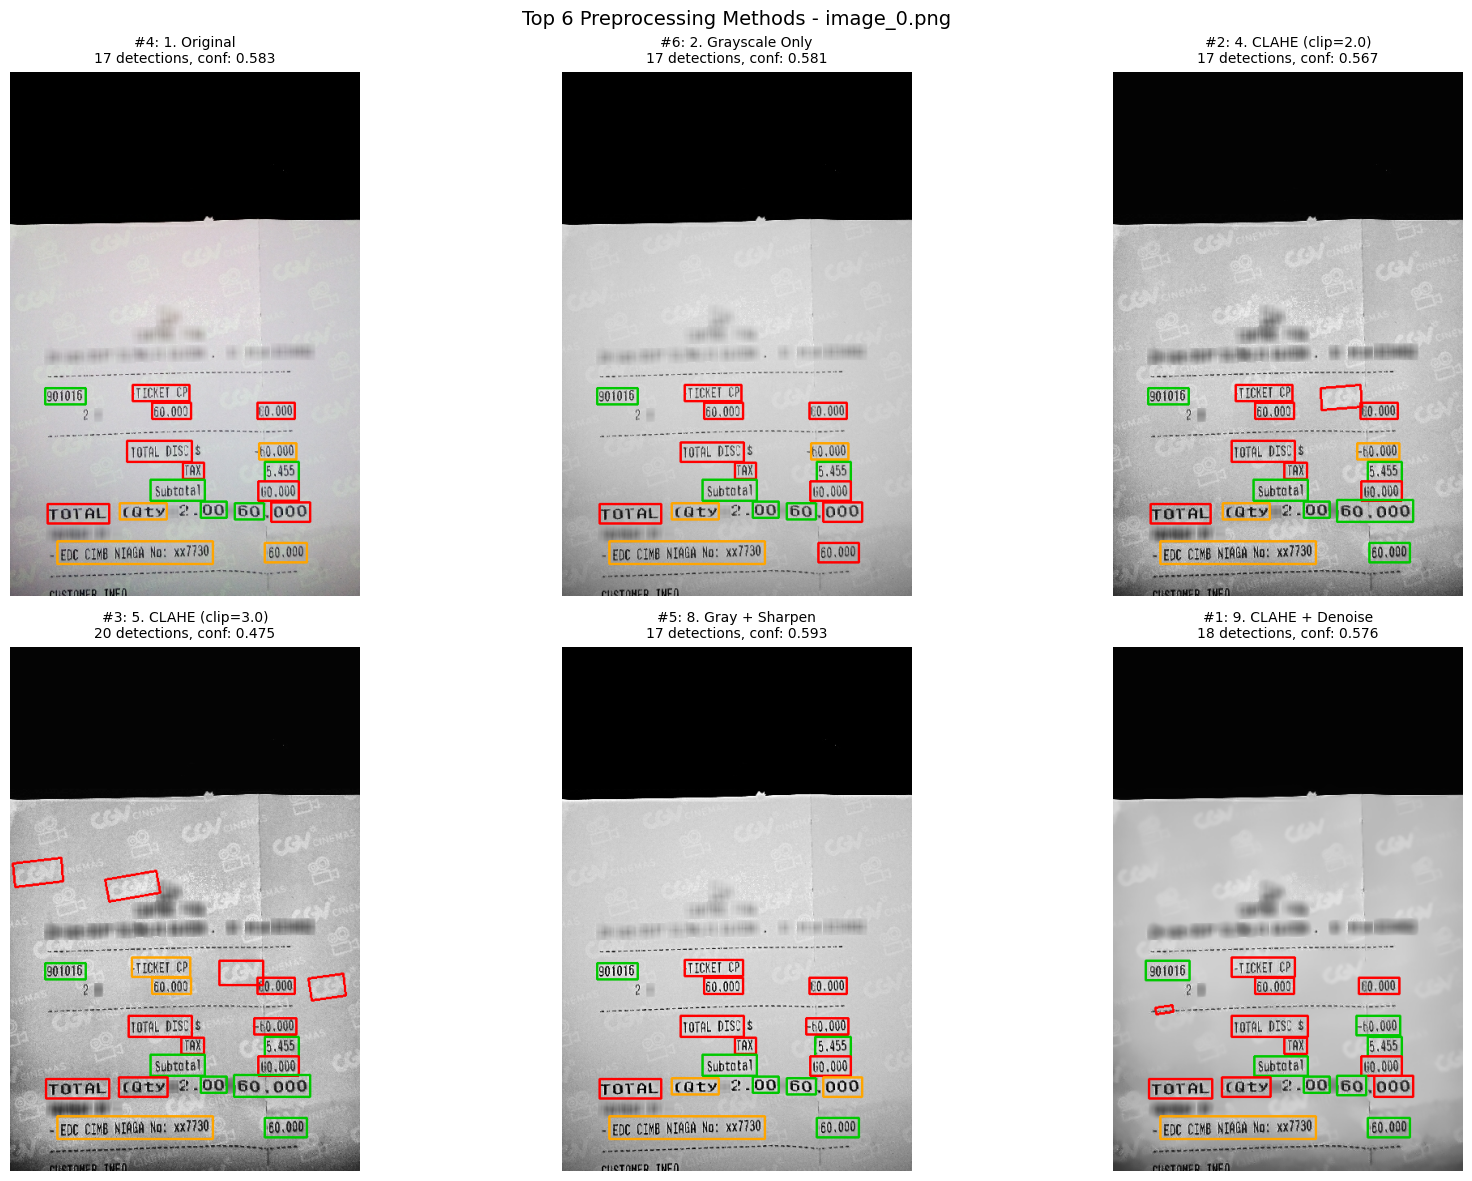


──────────────────────────────────────────────────────────────────────
📝 OCR Text from Best Method (9. CLAHE + Denoise):
──────────────────────────────────────────────────────────────────────
[[[40, 388], [94, 388], [94, 412], [40, 412]], '901016']
[[[146, 384], [224, 384], [224, 429], [146, 429]], '~TICKET CP 60,00o']
[[[303, 409], [353, 409], [353, 429], [303, 429]], 'Eo,000']
[[[44, 443], [370, 443], [370, 558], [44, 558]], '7cc TOTAL DIsc $ ~60,000 Tak 5,455 Subtota] 6O,000 TOTaL (Otv 00 60 0o0']
[[[58, 580], [250, 580], [250, 608], [58, 608]], 'EdC CIMB NIAGA No: xx7730']
[[[314, 582], [366, 582], [366, 606], [314, 606]], '60,000']


In [65]:
# Visualize top preprocessing methods on a sample image
print("=" * 70)
print("VISUAL COMPARISON: Top Methods on Sample Image")
print("=" * 70)

# Pick a sample image
sample_img_path = test_images[0][1]  # First image from test set
sample_img = cv2.imread(str(sample_img_path))
print(f"Sample: {sample_img_path.name}\n")

# Get top 6 methods to visualize
top_methods = [m[0] for m in method_avgs[:6]]

# Generate all configs and filter to top methods
all_configs = get_advanced_preprocessing_configs(sample_img)
top_configs = [(name, img) for name, img in all_configs if name in top_methods]

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (method_name, processed_img) in enumerate(top_configs):
    ax = axes[idx]
    
    # Run OCR
    results = reader.readtext(processed_img, detail=1)
    avg_conf = np.mean([r[2] for r in results]) if results else 0
    
    # Display image
    if len(processed_img.shape) == 3:
        display_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
    else:
        display_img = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2RGB)
    
    # Draw OCR boxes
    for bbox, text, conf in results:
        pts = np.array(bbox, dtype=np.int32)
        color = (0, 200, 0) if conf > 0.7 else (255, 165, 0) if conf > 0.5 else (255, 0, 0)
        cv2.polylines(display_img, [pts], True, color, 2)
    
    ax.imshow(display_img)
    rank = top_methods.index(method_name) + 1
    ax.set_title(f"#{rank}: {method_name}\n{len(results)} detections, conf: {avg_conf:.3f}", fontsize=10)
    ax.axis('off')

plt.suptitle(f'Top 6 Preprocessing Methods - {sample_img_path.name}', fontsize=14)
plt.tight_layout()
plt.show()

# Print OCR text from top method
print(f"\n{'─'*70}")
print(f"📝 OCR Text from Best Method ({top_methods[0]}):")
print(f"{'─'*70}")
best_config = [(name, img) for name, img in all_configs if name == top_methods[0]][0]
best_results = reader.readtext(best_config[1], detail=1, paragraph=True)
for text in best_results:
    if isinstance(text, tuple):
        print(text[1])
    else:
        print(text)

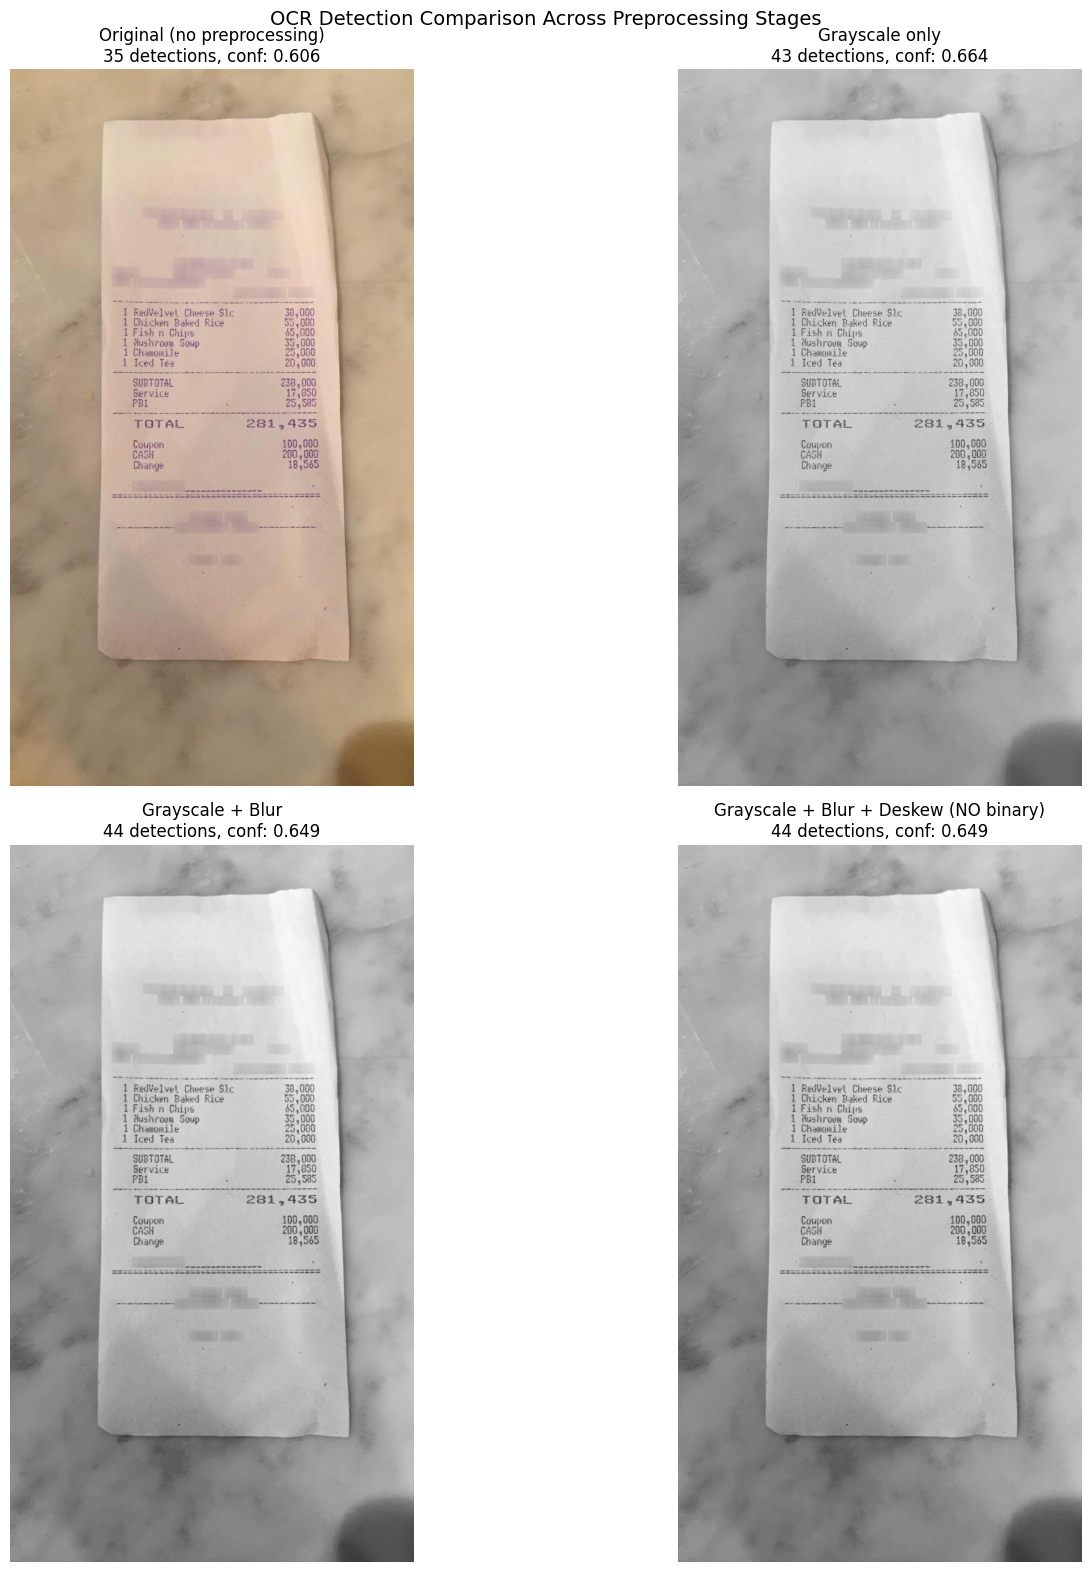


🏆 BEST CONFIG: Grayscale only
Full text from best config:
----------------------------------------------------------------------
1
RedVelvel
Cheesk SJC
30
4
Qo0
Chicken Baked Rile
55
0
Odo
1 Fish n
'Chip'$
65,@oo
Nushroum
35
5
Ooo
Chamomile
25
5
@oo
1
Iced Tea
z0 , OCo
SubtotAL
238 , Q0o
Service
17,850
Pbi
25
1
585
TOTAL
281,435
Coupon
100,QQ0
CASH
200
4
Qoo"
Change
18,565
Soup


In [61]:
# Side-by-side visual comparison of OCR results
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for idx, (name, img) in enumerate(test_configs):
    ax = axes[idx // 2, idx % 2]
    
    # Show image
    if len(img.shape) == 3:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        ax.imshow(img, cmap='gray')
    
    # Draw OCR detections
    results = reader.readtext(img, detail=1)
    for bbox, text, conf in results:
        pts = np.array(bbox, dtype=np.int32)
        # Draw on copy
        color = (0, 255, 0) if conf > 0.5 else (255, 0, 0)
        cv2.polylines(img if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 
                     [pts], True, color, 2)
    
    data = ocr_results[name]
    ax.set_title(f"{name}\n{data['num_detections']} detections, conf: {data['avg_confidence']:.3f}")
    ax.axis('off')

plt.suptitle('OCR Detection Comparison Across Preprocessing Stages', fontsize=14)
plt.tight_layout()
plt.show()

# Print the BEST result's full text
best_config = max(ocr_results.items(), key=lambda x: x[1]['avg_confidence'])
print(f"\n🏆 BEST CONFIG: {best_config[0]}")
print(f"Full text from best config:")
print("-" * 70)
print(best_config[1]['text'])